# Volume 3: Recurrent Neural Networks    
    Benj McMullin
    Math 405
    4/9/2024

In [2]:
!pip install --upgrade music21

In [3]:
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
        datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
        out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))


# Problem 1 #

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the 114215 Notes and Chords as strings.
There are many element types in MIDI files, so be sure to only look for Notes and Chords.
For the Chords, join the pitches of the Notes in the Chords with a . as in (D3.D2).

Print the length of your list and the number of unique Notes and Chords.


In [6]:
download_data(os.getcwd())

100%|██████████| 430509/430509 [00:00<00:00, 33302329.74it/s]

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [7]:
def order_pitches(pitches):
    """
    Orders a list of MIDI pitches and removes duplicates.

    Args:
    pitches (list): List of MIDI pitches.

    Returns:
    list: Sorted list of unique MIDI pitches as strings.
    """
    return sorted(list(set([str(n) for n in pitches])))

def mid(path):
    """
    Parses MIDI files in the specified directory.

    Args:
    path (str): Path to the directory containing MIDI files.

    Returns:
    list: List of notes and chords extracted from MIDI files as strings.
    """
    notes_chords = []

    # Iterate over each file in the directory
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        print("Processing:", file_path)

        # Parse the MIDI file
        midi = converter.parse(file_path)

        # Iterate over the notes and chords in the MIDI file
        notes_to_parse = instrument.partitionByInstrument(midi).parts.stream().recurse()
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                # If it's a single note, append its pitch
                notes_chords.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                # If it's a chord, extract its pitches, order them, and append as a joined string
                pitches = [str(p) for p in element.pitches]
                ordered_pitches = order_pitches(pitches)
                notes_chords.append('.'.join(ordered_pitches))

    return notes_chords

In [8]:
# Grab the data from the file
notes_chords = mid("mozart_sonatas/mozart_sonatas")

# Save the data to a file
print(len(notes_chords))

Processing: mozart_sonatas/mozart_sonatas/piano_sonata_576.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_279.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_545.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_330.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_281.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_280.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_593.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_400.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_283.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_570.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_457.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_547.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_310.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_332.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_309.mid
Processing: mozart_sonatas/mozart_sonatas/piano_sonata_

In [9]:
# Print the number of unique notes and chords
print(len(set(notes_chords)))

668


# Problem 2 #

Using the list returned in Problem 1, create the training, validation, and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.

2) Split the data into Long tensors of length 100.

3) Create the labels.

4) Randomly split the data into training, validation, and test sets using an 70/15/15 split (use torch.utils.data.random(data,lengths) where lengths=[0.7, 0.15, 0.15]).

5) Create the DataLoaders for these sets of data, using batch_size=128 for the training data and batch_size=32 for the validation and test data; also, set shuffle=True for the training data and False for the validation and test data (this is common practice in Deep Learning).


Print the length of each DataLoader (they should be 624, 536, and 536, respectively).

In [10]:
# Create a mapping of unique pitches to integers
pitches_integers = {pitch: i for i, pitch in enumerate(set(notes_chords))}

# Convert notes_chords to integer representations using the mapping
data = [pitches_integers[pitch] for pitch in notes_chords]

# Create sequences of 100 consecutive data points along with their labels
sequence_labels = []
for i in range(len(data) - 100):
    sequence = torch.LongTensor(data[i:i+100])  # Create a sequence of length 100
    label = data[i+100]  # Get the label for the next data point after the sequence
    sequence_labels.append([sequence, label])

In [11]:
# Set the lengths for train, validation, and test sets
# lengths = [79876, 17116, 17116]

# Calculate the total length of the dataset
total_length = len(sequence_labels)

# Calculate the lengths for train, validation, and test sets based on the total length
train_length = int(0.7 * total_length)
val_length = int(0.15 * total_length)
test_length = total_length - train_length - val_length

# Perform random split based on the calculated lengths
train, val, test = random_split(sequence_labels, lengths=[train_length, val_length, test_length])

# Define data loaders
train_loader = DataLoader(train, batch_size=128, shuffle=True, drop_last=True)
valid_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# Print the lengths of the loaders
print("Train Loader Length:", len(train_loader))
print("Validation Loader Length:", len(valid_loader))
print("Test Loader Length:", len(test_loader))

Train Loader Length: 624
Validation Loader Length: 535
Test Loader Length: 535


# Problem 3 #

Create an LSTM network class.
Have a hidden layer size of 256, and include at least $3$ LSTM layers.
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for a total of at least $3$ total BatchNorm layers.
The final layer should be a Softmax activation.

Initialize the model.
Define the loss as CrossEntropyLoss, and define the optimizer as RMSprop.

Train the model for 30 epochs.
Make sure to reinitialize the hidden states (h0, h1) for each training batch.
After taking a backwards step during training, scale the gradients using
nn.utils.clip_grad_norm_(model.parameters(), 5).
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of every epoch, calculate the validation accuracy and mean loss on the validation data.
Remember to change the model to eval() mode when running the validation data and then train() when running on the training data.
The hidden states (h0, h1) will also need to be reinitialized for each validation batch.

Once the training is complete, plot the training and validation losses versus epochs on the same plot.
Also, plot the validation accuracy versus epochs.
Then, print the final test accuracy by running the finished model on the test data.

In [12]:
class RNN(nn.Module):
    """Recurrent Neural Network Class"""

    def __init__(self, n_notes, embedding_dim):
        super(RNN, self).__init__()

        # Define hyperparameters
        self.hidden_size = 128
        self.num_layers = 3

        # Embedding layer
        self.embedding = nn.Embedding(n_notes, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True)

        # Batch normalization layers
        self.batch1 = nn.BatchNorm1d(self.hidden_size)
        self.batch2 = nn.BatchNorm1d(1000)
        self.batch3 = nn.BatchNorm1d(n_notes)

        # Linear layers
        self.linear1 = nn.Linear(self.hidden_size, 1000)
        self.linear2 = nn.Linear(1000, n_notes)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        # Loss function
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, hidden):
        # Embedding layer
        embeds = self.embedding(x)

        # LSTM layer
        lstm_out, hidden = self.lstm(embeds, hidden)
        out = self.batch1(lstm_out[:, -1])

        # First linear layer
        linear_out = self.relu(self.linear1(out))
        out = self.batch2(linear_out)

        # Second linear layer
        linear_out = self.relu(self.linear2(out))
        out = self.batch3(linear_out)

        # Final softmax layer
        x = self.softmax(out)

        return x, hidden

    def init_hidden(self, batch_size):
        # Initialize the hidden layers
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)

In [15]:
def train(model, train_loader, valid_loader, n_epochs):
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    # Set up progress bar
    loop = tqdm(total=len(train_loader), position=0)

    mean_train_losses, mean_valid_losses, mean_valid_accs = [], [], []
    for epoch in range(1, n_epochs + 1):
        model.train()
        (h0, h1) = model.init_hidden(128)

        train_losses = []
        for x_truth, y_truth in train_loader:
            x_truth, y_truth = x_truth.to(device), y_truth.to(device)
            optimizer.zero_grad()

            output, (h0, h1) = model(x_truth, (h0, h1))
            h0 = h0.detach()
            h1 = h1.detach()

            # Calculate Training Loss
            loss = model.loss(output, y_truth)
            train_losses.append(loss.item())
            loop.set_description(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
            loop.update()
            loss.backward()
            optimizer.step()
            nn.utils.clip_grad_norm_(model.parameters(), 5)

        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, 'mozart.ckpt')

        # Calculate Validation Loss and Accuracy
        validation = 0
        valid_losses = []
        model.eval()
        for x_truth, y_truth in valid_loader:
            x_truth, y_truth = x_truth.to(device), y_truth.to(device)
            (h0, h1) = model.init_hidden(len(y_truth))
            y_hat, _ = model(x_truth, (h0, h1))
            loss = model.loss(y_hat, y_truth)
            valid_losses.append(loss.item())

            validation += sum(torch.eq(y_truth, y_hat.argmax(1))) / len(y_truth)

        mean_valid_acc = validation.item() / len(valid_loader)

        mean_train_losses.append(np.mean(train_losses))
        mean_valid_accs.append(mean_valid_acc)
        mean_valid_losses.append(np.mean(valid_losses))

        # Early stopping based on validation accuracy
        if mean_valid_acc > 0.6:
            loop.close()
            break

    loop.close()

    return model, mean_train_losses, mean_valid_losses, mean_valid_accs

In [16]:
# Instantiate the RNN model
rnn_model = RNN(n_notes=668, embedding_dim=32)

# Move the model to the appropriate device (e.g., GPU if available)
rnn_model.to(device)

# Train the model
model, train_loss, valid_loss, valid_accs = train(rnn_model, train_loader, valid_loader, n_epochs=30)

Epoch: 30, Loss: 0.7036: : 18720it [06:34, 47.45it/s]


In [17]:
# Save the model checkpoint
torch.save({'epoch': 30,
                   'model_state_dict': model.state_dict(),
                   'loss': train_loss[-1]}, 'mozart.ckpt')

In [22]:
# Calculate Test Accuracy
test_score = 0
model.eval()

# Load the model checkpoint
for x_truth, y_truth in test_loader:
    x_truth, y_truth = x_truth.to(device), y_truth.to(device)
    (h0, h1) = model.init_hidden(len(y_truth))
    y_hat, _ = model(x_truth, (h0, h1))

    # Calculate Test Accuracy
    test_score += sum(torch.eq(y_truth, y_hat.argmax(1))) / len(y_truth)

# Calculate the mean test accuracy
mean_test_acc = test_score.item() / len(test_loader)

In [23]:
# Print the mean test accuracy
print("Test Accuracy: ", mean_test_acc)

Test Accuracy:  0.4580101227091852


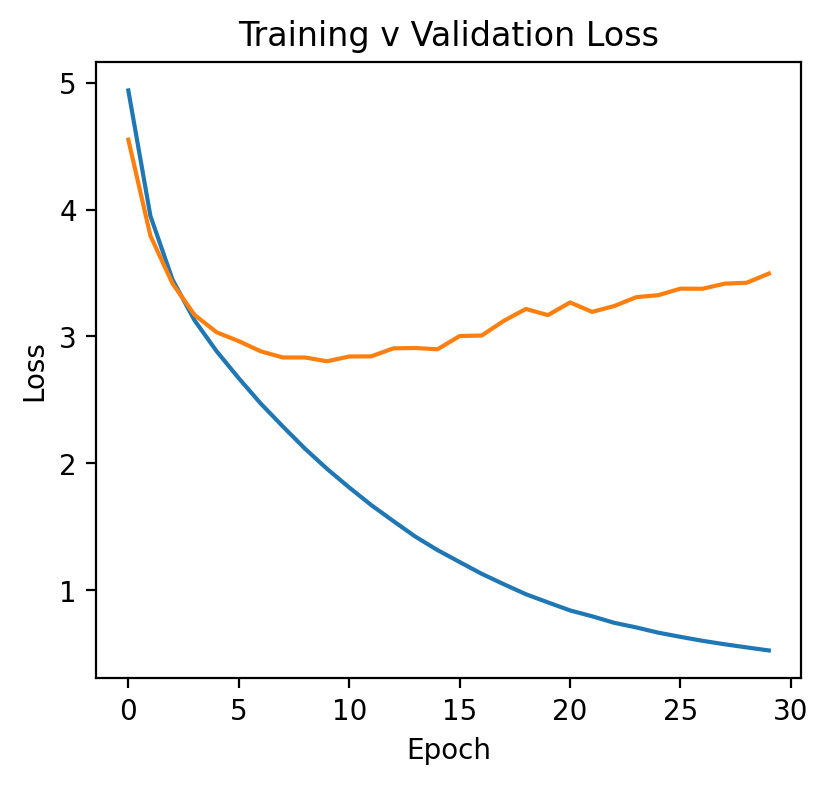

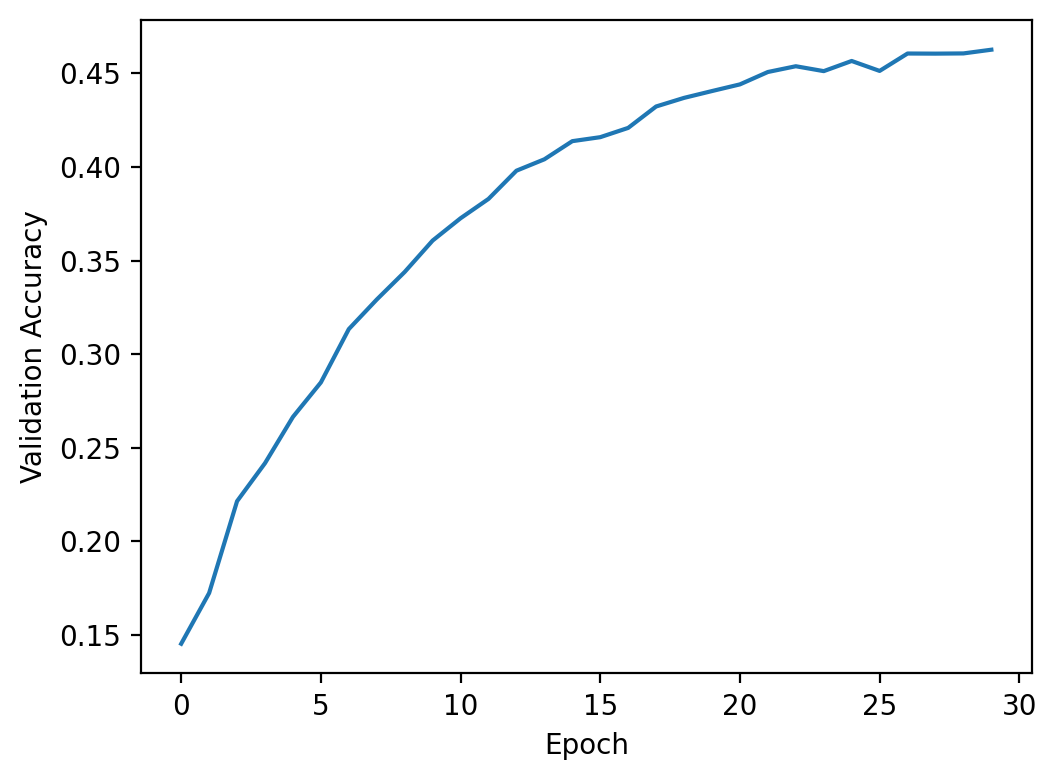

In [24]:
# Plot it
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(train_loss, label = "Training Loss")
plt.plot(valid_loss, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training v Validation Loss")

plt.figure(figsize=(10, 4))
plt.subplot(122)
plt.plot(valid_accs)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

plt.tight_layout()
plt.show()

# Problem 4 #

Write a function that randomly chooses a sequence in the test data (which has length 10) and predicts the next $n$ elements, defaulting to 500.
Convert the predicted elements to pitches, and return them as a list of length $n$.

In [25]:
def load_model(filename):
    """Load a saved model to continue training or evaluate."""
    # Determine the device (GPU if available, otherwise CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Instantiate the model with the appropriate parameters
    model = Network(n_notes, 32)
    model = model.to(device)

    # Define loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

    # Load model checkpoint
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    # Set model to evaluation mode
    model.eval()

    return model, criterion, optimizer

In [26]:
def predict(n):
    """Generate a sequence of predicted values."""
    # Move the model to the appropriate device (e.g., GPU if available)
    model.to(device)

    # Choose a random sequence and its corresponding label from the test set
    idx = np.random.randint(0, len(test))
    seq, label = test[idx][0], test[idx][1]

    # Convert the sequence to a list
    seqs = seq.tolist()

    # Initialize the hidden states
    (h0, h1) = model.init_hidden(1)

    # Generate the predicted sequence
    for _ in range(n):
        seq = seq.unsqueeze(0).to(device)
        y_hat, _ = model(seq, (h0, h1))
        seqs.append(y_hat.argmax(1).item())
        seq = torch.LongTensor(seqs[-100:])

    return seqs

In [27]:
# Generate a sequence of predicted values
prediction = predict(500)

In [28]:
# Convert the predicted values to pitches
key_list = list(pitches_integers.keys())
val_list = list(pitches_integers.values())

# Convert the predicted values to pitches
pitches = [key_list[val_list.index(i)] for i in prediction]
print(pitches)

['B3', 'D5', 'G3', 'D5', 'B3', 'E5', 'D3', 'D5', 'B3', 'C5', 'G3', 'B4', 'B3', 'B4', 'D3', 'D4', 'G3', 'D4', 'A4.B4', 'D3', 'A4.B4', 'C4', 'A4.B4', 'F#3', 'A4.G4', 'C4', 'G4', 'G3', 'B3', 'G4', 'B3', 'D5', 'G3', 'B3', 'G4', 'E5.F#5', 'D5', 'B3', 'D6', 'G3', 'A3', 'C6', 'F#4', 'A3', 'B5', 'G3', 'C4', 'A5', 'F#4', 'C4', 'G5', 'G3', 'B3', 'G4', 'B3', 'D5', 'G3', 'B3', 'G4', 'E5.F#5', 'D5', 'B3', 'D6', 'G3', 'A3', 'C6', 'F#4', 'A3', 'B5', 'G3', 'C4', 'A5', 'F#4', 'C4', 'G5', 'G3', 'B3', 'G4', 'B3', 'D5', 'G3', 'D6', 'C4', 'F#4', 'A5.B5.C6', 'C4', 'G5', 'G3', 'B3', 'G4', 'B3', 'D5', 'G3', 'D6', 'C4', 'F#4', 'A5.B5.C6', 'C4', 'G5', 'B3.G4', 'D5.F5', 'G5', 'C5.E5', 'G4', 'G5', 'F#4', 'C#6.D6', 'D4', 'A4.D5', 'G5', 'G4', 'G#5', 'D4', 'F5', 'G4', 'D4', 'G4', 'G5', 'G4', 'G5', 'D4', 'G5', 'G4', 'G#5', 'C4', 'G5', 'G4', 'F5', 'C4', 'E-5', 'G4', 'C4', 'G4', 'D5', 'G3', 'G4', 'B3', 'C5', 'D5', 'G4', 'E-5', 'C4', 'G4', 'G5', 'F#5', 'G5', 'E-4', 'G3', 'B-3.E-3.G3', 'G5', 'E-4', 'E-5', 'G4', 'E-4.G4',

# Problem 5 #

Convert the predictions from Problem 4 into Music21 Note and Chord objects and save it as 'mozart.mid'. Embed your music file into the notebook.

In [38]:
note_stream = stream.Stream()
chord_stream = stream.Stream()

# Populate notes and chords lists
notes = []
chords = []

for offset, pitch in enumerate(pitches):
    if '.' in pitch:
        # Process as a chord
        chord_pitches = pitch.split('.')
        new_chord = chord.Chord(chord_pitches)
        new_chord.storedInstrument = instrument.Piano()
        new_chord.offset = offset
        chords.append(new_chord)
    else:
        # Process as a single note
        new_note = note.Note(pitch)
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset
        notes.append(new_note)

# Append notes to note stream
note_stream.append(notes)

# Append chords to chord stream
chord_stream.append(chords)

# Combine both streams
midi_stream = stream.Stream()
midi_stream.append(note_stream)
midi_stream.append(chord_stream)

# Write the MIDI file
midi_stream.write('midi', fp='mozart.mid')

Epoch: 1, Loss: 4.1618: 100%|██████████| 624/624 [24:01<00:00,  2.31s/it]


'mozart.mid'